In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

%matplotlib inline


# The Rossler model

In [2]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param

    #define states
    X,Y,Z=y

    #define derivatives
    dX_dt = -Y - Z
    dY_dt = X + a*Y
    dZ_dt = b + Z*(X-c)
    
    return dX_dt,dY_dt,dZ_dt
    
def model_sol(param):
    
    y0 = [4.,4.,0.1]
    time = np.linspace(0, 500, 1000)

    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

# Fake data

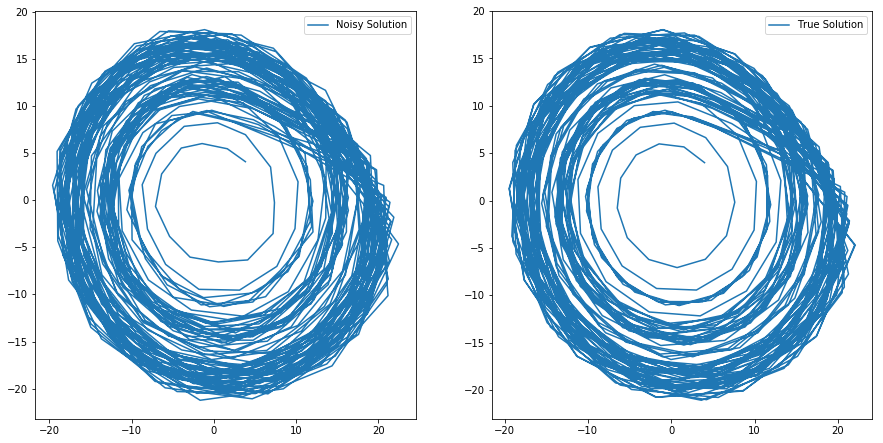

In [3]:
time = np.linspace(0, 500, 1000)

sol=model_sol([0.1,0.1,14.])
Y=np.ones((len(time),3))
for states in range(3):
    Y[:,states] = sol[:,states] + np.random.randn(len(time),)*(0.025*np.std(sol[:,states]))
plt.figure(figsize=(15, 7.5))
plt.subplot(1,2,1)
plt.plot(Y[:,0],Y[:,1], label='Noisy Solution')
plt.legend()
plt.subplot(1,2,2)
plt.plot(sol[:,0],sol[:,1], label='True Solution')
plt.legend()

# Define GP state & velocity estimators

In [4]:
def smooth_gp(traces, input_time, true_sol=None, optim_restarts = 1):
    time_len = len(input_time)
    gp_models = []
    state = []
    velocity = []
    for states in xrange(traces.shape[1]):
        kern = GPy.kern.Matern32(1) + GPy.kern.Bias(1) 
        gp_models.append(GPy.models.GPRegression(input_time, 
                                    traces[-time_len:,states].reshape(len(input_time),1), kern))
    start = 400
    stop = 500
    window = [start,stop]
    for states in xrange(traces.shape[1]):
        gp_models[states].optimize_restarts(optimizer='lbfgs',messages=False,
                                           num_restarts = optim_restarts)
        state.append(gp_models[states].posterior_samples_f(input_time,size=10))
        velocity.append(gp_models[states].predictive_gradients(input_time)
                       [0].reshape(len(input_time),))
        gp_models[states].plot_noiseless(window)
        if not(true_sol) == None:
            plt.plot(input_time[-500:],true_sol[-500:,states],
                     color='#ff7f0e',lw=1.5,label='state '+str(states+1))
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
    return state, velocity, gp_models

Optimization restart 1/1, f = 2511.75171418


 C:\Users\sanmi\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:20: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


Optimization restart 1/1, f = 2300.30588741
Optimization restart 1/1, f = 2714.68074956


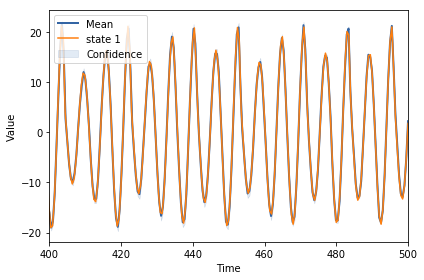

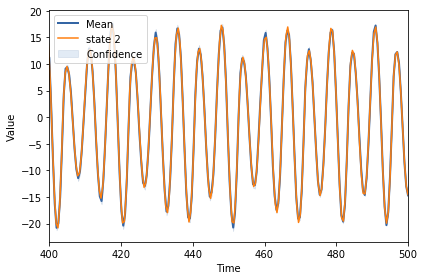

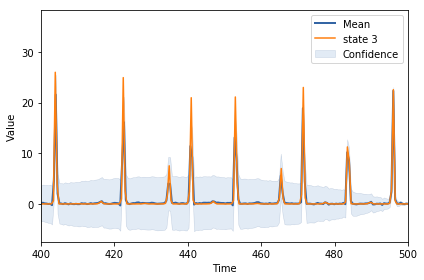

In [6]:
input_time=time.reshape(1000,1)
gp_kernel = GPy.kern.Matern32(1) + GPy.kern.Bias(1)
xbar, dxbar, gps = smooth_gp(Y, input_time, sol)

# The ODE R.h.s function

In [7]:
def simulation_rhs_f(trial):
    stateLen = 1000
    sample = 10
    xbar_X, xbar_Y, xbar_Z = xbar
    rhsf_X = np.ones((stateLen,sample))
    rhsf_Y = np.ones((stateLen,sample))
    rhsf_Z = np.ones((stateLen,sample))
    for t in range(stateLen):
        for j in range(sample):
            rhsf_X[t,j] = -xbar_Y[t,j] - xbar_Z[t,j]
            rhsf_Y[t,j] = xbar_X[t,j] + trial[0]*xbar_Y[t,j]
            rhsf_Z[t,j] = trial[1] + xbar_Z[t,j]*(xbar_X[t,j]-trial[2])
    
    if np.any(np.array([trial])<0.0):
        rhsf_X[0,:]=-1000.
        rhsf_Y[0,:]=-1000.
        rhsf_Z[0,:]=-1000.
       
    return np.array([rhsf_X.mean(axis=1),rhsf_Y.mean(axis=1),rhsf_Z.mean(axis=1)])

# Euclidean distance metric

In [8]:
def dist_metric(d,x):
    dist=0.0
    for states in range(3):
        if np.all(np.array(x[states][0]==-1000.0)):
            dist += np.inf
        else:
            dist += np.sum((d[states]-x[states])**2)    
            
    return dist  

In [9]:
data = dxbar
priors =  [('gamma', [2.0,1.]), ('uniform', [0.0,2.]), ('uniform', [5.0,40.0])]

In [17]:
from abcsmc.abcsmc import ABCSMC

In [31]:
model_sim = simulation_rhs_f
sampler = ABCSMC(3,100,data,30,priors,model_sim,dist_metric,[1.5e6,100],quantile=75)
samples = sampler.sample()

('\t Stage:', 0, '\t tol:', 1500000.0, '\t Params:', [1.3568349305709122, 0.90738049162804768, 13.74534490934278])
('\t Step:', 1, '\t epsilon_t:', 1076178.9859718648, '\t Params:', [1.0771575442994474, 1.2842291334548579, 14.175740383854619])
('\t Step:', 2, '\t epsilon_t:', 839321.4130968817, '\t Params:', [1.0255186957242719, 1.3008592935237675, 14.255730199391987])
('\t Step:', 3, '\t epsilon_t:', 622663.12137832446, '\t Params:', [0.98132763009332313, 1.3162145999971768, 13.939355227688868])
('\t Step:', 4, '\t epsilon_t:', 508923.33566862007, '\t Params:', [0.87057307112828175, 1.2192451927631383, 14.495806919805627])
('\t Step:', 5, '\t epsilon_t:', 430204.81226042547, '\t Params:', [0.63724443847449386, 1.1690263880658365, 14.971575554281078])
('\t Step:', 6, '\t epsilon_t:', 336277.26252311666, '\t Params:', [0.58569646243019546, 1.1425059087801661, 14.28138495158678])
('\t Step:', 7, '\t epsilon_t:', 273955.36355559324, '\t Params:', [0.46359775982568097, 1.3386399830176279, 

# Get posterior predicted attractors

In [32]:
def model_sol_pos(param,init):
    y0 = init
    time = np.linspace(0, 500, 500000)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return solution

# Initial values as smoothed GP state estimates

In [33]:
init=[xbar[0][0,:].mean(axis=0),xbar[1][0,:].mean(axis=0),xbar[2][0,:].mean(axis=0)]

# Solve attractors at center and bounds of marginals

In [34]:
def plot_pos(soln_fn, step, sampler, init):
    center = []
    upper = []
    lower = []
    for par in xrange(sampler.nparam):
        center.append(np.mean(sampler.theta[step][:,par]))
        upper.append(np.mean(sampler.theta[step][:,par])+1.96*np.std(sampler.theta[step][:,par]))
        lower.append(np.mean(sampler.theta[step][:,par])+1.96*np.std(sampler.theta[step][:,par]))
    mean_soln = soln_fn(center,init)
    lower_soln = soln_fn(lower,init)
    upper_soln = soln_fn(upper,init)
    
    return mean_soln, lower_soln, upper_soln

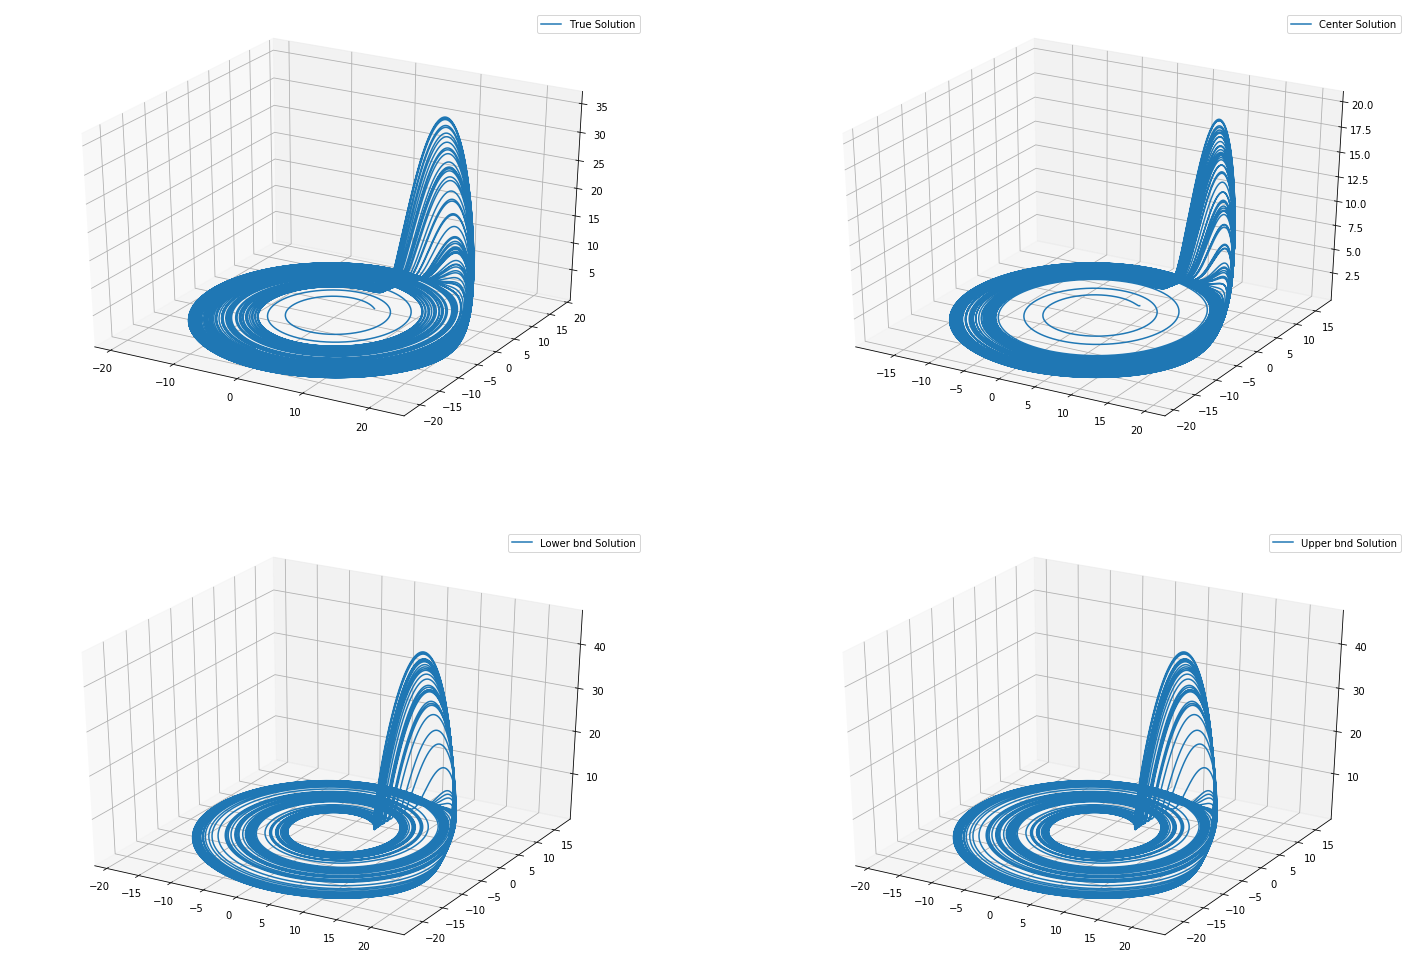

In [35]:
msol, lsol, usol = plot_pos(model_sol_pos, 24, sampler, init)
true_init = [sol[0,0], sol[0,1], sol[0,2]]
true_soln = model_sol_pos([0.1,0.1,14],true_init)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25, 17.5))
ax = fig.add_subplot(221, projection='3d')
plt.plot(true_soln[:,0],true_soln[:,1],true_soln[:,2], label ='True Solution')
plt.legend()
ax = fig.add_subplot(222, projection='3d')
plt.plot(msol[:,0],msol[:,1],msol[:,2], label ='Center Solution')
plt.legend()
ax = fig.add_subplot(223, projection='3d')
plt.plot(lsol[:,0],lsol[:,1],lsol[:,2], label ='Lower bnd Solution')
plt.legend()
ax = fig.add_subplot(224, projection='3d')
plt.plot(usol[:,0],usol[:,1],usol[:,2], label ='Upper bnd Solution')
plt.legend()


In [ ]:
import seaborn as sns
sns.kdeplot()